In [1]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [2]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

In [4]:
domain = [0, 1]

# Seperation
C = 0.62 #eta0 = etaV
# C = 0.48 #eta0 != etaV
Δ = C/fc

x0 = [0.5-.5Δ, 0.5+.5Δ]
a0 = [1.0, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure{Float64}([0.44833333333333336, 0.5516666666666666], [1.0, -1.0], 1, 2)

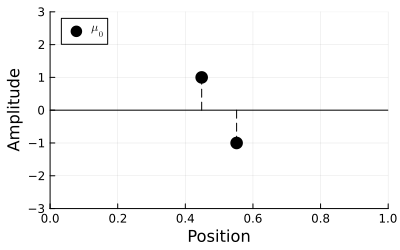

In [25]:
n_coarse_grid = 21
n_plt_grid = 1001

plt_grid = grid(domain, n_plt_grid)
plot_size = (400, 250) .* 1
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=100)
hline!(plt, [0], linestyle=:solid, color=:black, label="", legendposition=:topleft)

# plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:yellow, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=2)
plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:black, label=L"μ_0", marker=:circle, markersize=7, markerstrokewidth=0)
for (xi, ai) in zip(μ0.x, μ0.a)
    plot!(plt, [xi, xi], [0, ai], linestyle=:dash, color=:black, label="")
end
plt

In [26]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]), var"#Φ#13"{var"#ϕ#12"{Float64, Vector{Int64}}}(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Vector{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, Vector{Int64}}}(var"#ϕ#12"{Float64, Vector{Int64}}(0.2773500981126146, [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]))), :fourier)

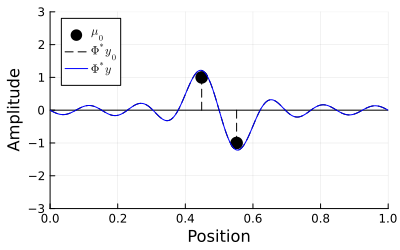

In [27]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^{\ast}y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^{\ast}y", color=:blue)

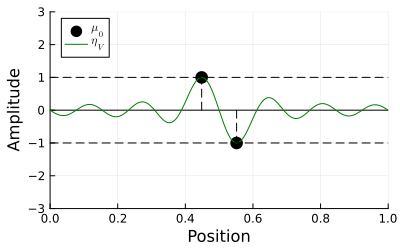

In [22]:
ηV = build_ηV(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV(plt_grid), label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [ ]:
λ = 0

prob = BLASSO(y, ops, domain, n_coarse_grid, λ=λ)

prob_sdp = deepcopy(prob)
solve!(prob_sdp, :SDP)

DiscreteMeasure{Float64}(Float64[], Float64[], 1, 0)

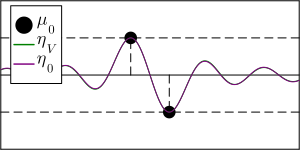

In [32]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.adjΦ(prob_sdp.p) * sqrt(n)
# plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
plot!(plt_sdp, plt_grid, ηλ, label=L"η_0", color=:purple)
# hline!(plt_sdp, [1, -1], linestyle=:dash, color=:black, label="")
# plot!(plt_sdp, prob_sdp.μ.x, prob_sdp.μ.a, seriestype=:scatter, color=:red, label=L"μ_λ", marker=:x, markersize=10, markerstrokewidth=2)


using Plots.Measures
plot!(
    markerstrokewidth=0,
    xlabel="", ylabel="",
    legend=:topleft, legendfontsize=12,
    ticks=false, frame=:box,
    xlims=(0.1, 0.9), ylims=(-2, 2),margins=-1.8mm,
    size=(300,150))
    # size=plot_size ./ 1.5)

In [11]:
# savefig(plt_sdp, "../../figures/1D/CloseOpposite-$C.svg")

In [12]:
# savefig(plt_sdp, "../../figures/PreCertificates/eta0eqetaV.svg")
# savefig(plt_sdp, "../../figures/PreCertificates/eta0neqetaV.svg")